# The SOAP descriptor, Gaussian Approximation Potentials (GAP) and machine-learning of force fields 

Adam Fekete, Matrina Stella, Henry Lambert, Alessandro De Vita, Gabor Csanyi (gc121@cam.ac.uk)

## Introduction

In this tutorial we will be using a Gaussian Approximation Potentials to analyse results of TB DFT calculations of Si surface. Along the way we will learn about different descriptors (2b, 3b, soap) to describe local atomic environment in order to predict energies and forces of Si surface. 



In [1]:
import os

import numpy as np
import matplotlib.pylab as plt

from quippy.potential import Potential
from quippy.descriptors import Descriptor

from ase import Atoms, units 
from ase.build import add_vacuum
from ase.lattice.cubic import Diamond
from ase.io import write

from ase.constraints import FixAtoms

from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase.md.langevin import Langevin

from ase.optimize.precon import PreconLBFGS, Exp

from gap_si_surface import ViewStructure

_ColormakerRegistry()

## Part I: MD, descriptors
### Parameters

We can define some parameters here for the MD calculations:

In [2]:
T = 1000.0 # Temperature [Kelvin]
timestep = 1.0 * units.fs

## System

Defining configuration for Si slab

In [3]:
def build_slab(size=(1,2,2), vacuum=10.):
    # Build Si lattice.
    # lattice = Diamond('Si', directions=([1, 0, 0], [0, 1, 0], [0, 0, 1]), latticeconstant=5.44, size=size)
    lattice = Diamond('Si', latticeconstant=5.44, size=size)
    atoms = Atoms(lattice)
    

    # Fixing the bottom layer     
    bottom = atoms.positions[:,2].min()
    fixed_mask = (abs(atoms.positions[:,2] - bottom) < 2.0)
    atoms.set_constraint(FixAtoms(mask=fixed_mask))
    
    # build surface by adding space to z direction
    add_vacuum(atoms, vacuum)
    # atoms.center(vacuum=10.0, axis=2)
    
    return atoms


atoms = build_slab()
print('Number of atoms:', len(atoms))

Number of atoms: 32


Let's visualise the initial configuration:

In [4]:
view = ViewStructure(atoms, repetition=(2,2,1))
view

NGLWidget()

## MD dynamics with TB DFTB

We use TB DFTB potential to calculate the potential energies and forces for the each timestep:

In [5]:
# attach tight binding calculator
qm_pot = Potential('TB DFTB', param_filename='dftb-params.xml')
atoms.set_calculator(qm_pot)

# Thermalize atoms
MaxwellBoltzmannDistribution(atoms, 2.0 * T * units.kB)
# dynamics = VelocityVerlet(atoms, timestep)
dynamics = Langevin(atoms, timestep, T * units.kB, 0.002)
    
#attach observer to dynamics to track quantity of interest (temperature)
def print_status():    
    print('Step = {}, time = {} [fs], T = {} [K]'.format(
        dynamics.nsteps,
        dynamics.nsteps * dynamics.dt / units.fs,
        atoms.get_kinetic_energy() / (1.5 * units.kB * len(atoms))
    ))

def print_energy(a=atoms):  # store a reference to atoms in the definition.
    """Function to print the potential, kinetic and total energy."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))
    
dynamics.attach(print_status, interval=10)
dynamics.attach(print_energy, interval=1)

Let's do the dynamics:

In [6]:
dynamics.run(steps=100)

# for _ in range(150):
#     dynamics.run(steps=1)

Step = 0, time = 0.0 [fs], T = 2126.2241342902184 [K]
Energy per atom: Epot = -34.783eV  Ekin = 0.275eV (T=2126K)  Etot = -34.509eV
Energy per atom: Epot = -34.782eV  Ekin = 0.263eV (T=2037K)  Etot = -34.519eV
Energy per atom: Epot = -34.778eV  Ekin = 0.260eV (T=2010K)  Etot = -34.519eV
Energy per atom: Epot = -34.772eV  Ekin = 0.253eV (T=1960K)  Etot = -34.519eV
Energy per atom: Epot = -34.764eV  Ekin = 0.244eV (T=1891K)  Etot = -34.520eV
Energy per atom: Epot = -34.754eV  Ekin = 0.234eV (T=1810K)  Etot = -34.520eV
Energy per atom: Epot = -34.743eV  Ekin = 0.222eV (T=1721K)  Etot = -34.521eV
Energy per atom: Epot = -34.731eV  Ekin = 0.211eV (T=1633K)  Etot = -34.520eV
Energy per atom: Epot = -34.718eV  Ekin = 0.197eV (T=1522K)  Etot = -34.521eV
Energy per atom: Epot = -34.704eV  Ekin = 0.183eV (T=1418K)  Etot = -34.521eV
Step = 10, time = 10.0 [fs], T = 1307.506208654726 [K]
Energy per atom: Epot = -34.690eV  Ekin = 0.169eV (T=1308K)  Etot = -34.521eV
Energy per atom: Epot = -34.676eV

Step = 100, time = 100.00000000000001 [fs], T = 1584.1973113365673 [K]
Energy per atom: Epot = -34.723eV  Ekin = 0.205eV (T=1584K)  Etot = -34.518eV


True

In [8]:
view = ViewStructure(atoms)
view

NGLWidget()

## Using descriptors

In this section we will intorduce some descriptors which could be useful for describing local atomic enviroments

You can find more details in the [descriptor tutorial](./quippy-descriptor-tutorial.ipynb).

## Pairwise

Here we use a simple pair distance between Silicon atoms, with a cutoff of 4.0 Angstrom. There are several descriptors that can do this, one is distance_2b, which takes a cutoff argument. Alternatively, the distance_Nb descriptor could also do this, with order=2. This is more general, order=3 is a triangle-like three-body descriptor of the three sides of a triangle of 3 atoms.

In [7]:
desc = Descriptor("distance_Nb order=2 cutoff=4.0 n_Z=1 Zs={14}")

This descriptor is very simple: it is scalar (dimension 1), and hence only has a two (but equivalent) permutations.

In [9]:
desc.n_perm

2

In [10]:
desc.cutoff()

4.0

In [11]:
desc.permutations() # array of permutation arrays


array([[1],
       [1]], dtype=int32)

Many descriptors rely on the neighbour connectivity, so we need to call calc_connect, after setting the Atoms cutoff:

In [12]:
desc.cutoff()

4.0

We can now calculate how many instances of this descriptor are found in an Atoms (or ASEAtoms) object:

In [13]:
desc.count(atoms)

195

This also works transparently for iterables (such as lists), returning a list of the counts.

We can also calculate the actual descriptor values â€“ in this case, the list of pairwise distances:

In [14]:
d = desc.calc(atoms)
# for k,v in d.items():
#     print(k)
#     print(type(v))
d

{'covariance_cutoff': array([1.00000000e+00, 2.14658119e-01, 2.14658119e-01, 3.19795982e-01,
        6.76831904e-01, 2.14658119e-01, 2.14658119e-01, 1.00000000e+00,
        1.92216892e-01, 1.00000000e+00, 2.14658119e-01, 2.14658119e-01,
        1.00000000e+00, 5.49473573e-01, 1.02669964e-01, 1.00000000e+00,
        2.14658119e-01, 2.14658119e-01, 4.28565697e-03, 1.00000000e+00,
        5.32303157e-01, 5.65893474e-02, 3.17080099e-02, 2.14658119e-01,
        2.14658119e-01, 7.67705096e-02, 3.88763394e-01, 1.00000000e+00,
        2.05886791e-01, 5.65694781e-02, 1.00000000e+00, 2.14658119e-01,
        2.14658119e-01, 1.00000000e+00, 3.82420324e-01, 1.00000000e+00,
        1.54120671e-01, 4.61381664e-01, 1.00000000e+00, 2.79930187e-01,
        3.74608882e-02, 1.00000000e+00, 5.43735112e-01, 2.22676798e-01,
        1.00000000e+00, 1.94241936e-03, 9.23567078e-02, 2.15915262e-01,
        3.36721166e-01, 1.00000000e+00, 1.21132692e-01, 1.00000000e+00,
        3.58304355e-07, 1.00000000e+00, 2.2

Notice that the first array is called cutoff, and it supplies the value of a cutoff function, implicit in all descriptors, which takes the descriptor value to zero as the atoms approach the cutoff, i.e. in this case as the distance between the two atoms approaches the cutoff. It is more complicated for three-body and higher-body descriptors, but the final result is always a descriptor which changes smoothly with atomic positions.

Here is a histogram of the resulting descriptor array, i.e. of the interatomic distances

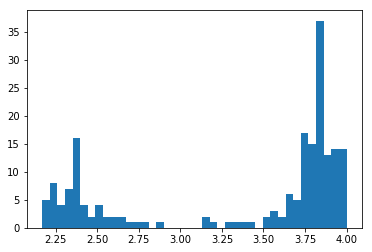

In [15]:
plt.hist(d['data'], bins=40)
plt.show()

Calculate size of descriptor data:


In [16]:
desc.sizes(atoms)

(195, 390)

In [17]:
n_desc, n_cross = desc.sizes(atoms)
print("n_desc=%d n_cross=%d" % (n_desc, n_cross))

n_desc=195 n_cross=390


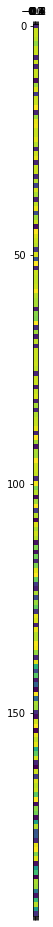

In [18]:
plt.matshow(d['data'])

## SOAP descriptor

We will describe the environment using the SOAP descriptor. The SOAP descriptor of an atomic environment is based on a spherical harmonic expansion of the neighbour density, and truncating this expansion at some maximum numer of radial (n_max) and angular (l_max) indices gives rise to some parameters. We also need to give the cutoff within which we consider the neighbour environment.

Writing the descriptor vector as $p_{ss'nn'l}$, where $s$ and $s'$ are indices that run over the different atomic species in the atom's environment, $n$ and $n'$ are radial and $l$ is an angular index.

In [19]:
desc = Descriptor("soap cutoff=4 l_max=3 n_max=4 normalize=T atom_sigma=0.5 n_Z=1 Z={14} ")

There are now only 32 descriptors, because SOAP produces one for each atom in the structure

In [20]:
desc.sizes(atoms)


(32, 422)

But each descriptor now is a long vector, because it encodes the entire environment of the atom up to the cutoff. The length of the vector depends on l_max and n_max and also on the number of atom types.

In [21]:
d = desc.calc(atoms)
d

{'covariance_cutoff': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'data': array([[8.72484873e-01, 1.34159734e-04, 1.36705926e-04, ...,
         2.59809734e-08, 1.14112318e-08, 0.00000000e+00],
        [7.59438258e-01, 2.64988180e-05, 2.06399928e-05, ...,
         1.47470244e-08, 3.98299197e-09, 0.00000000e+00],
        [8.98417344e-01, 1.38097131e-04, 1.40770407e-04, ...,
         1.20256730e-08, 2.19962174e-09, 0.00000000e+00],
        ...,
        [5.38846271e-01, 2.19806777e-05, 2.34697590e-04, ...,
         1.34797058e-07, 1.20892097e-07, 0.00000000e+00],
        [7.09890531e-01, 7.00599810e-05, 1.33968447e-04, ...,
         4.63712579e-08, 2.52251585e-08, 0.00000000e+00],
        [7.21058218e-01, 8.57141183e-05, 5.79089330e-05, ...,
         8.82576223e-08, 3.07146036e-08, 0.00000000e+00]]),
 'has_data': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    

We can visualise the values of the descriptor to have an idea of how vector looks like:

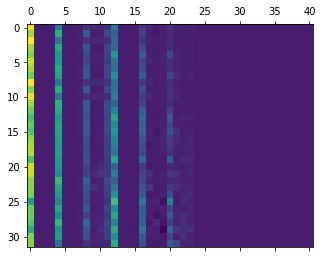

In [22]:
plt.matshow(d['data'])

## Part II: GAP: fitting, comparing different descriptors 


## Database

Let's run the MD to generate configurations for the training:

In [25]:
db = []
def collect_data():
    db.append(atoms.copy())

dynamics.attach(collect_data, interval=10)
dynamics.run(steps=500)

Energy per atom: Epot = -34.670eV  Ekin = 0.142eV (T=1100K)  Etot = -34.528eV
Energy per atom: Epot = -34.671eV  Ekin = 0.143eV (T=1106K)  Etot = -34.528eV
Energy per atom: Epot = -34.673eV  Ekin = 0.146eV (T=1127K)  Etot = -34.528eV
Energy per atom: Epot = -34.675eV  Ekin = 0.147eV (T=1140K)  Etot = -34.528eV
Energy per atom: Epot = -34.677eV  Ekin = 0.149eV (T=1152K)  Etot = -34.528eV
Energy per atom: Epot = -34.679eV  Ekin = 0.151eV (T=1169K)  Etot = -34.528eV
Energy per atom: Epot = -34.681eV  Ekin = 0.153eV (T=1181K)  Etot = -34.528eV
Energy per atom: Epot = -34.682eV  Ekin = 0.154eV (T=1188K)  Etot = -34.529eV
Energy per atom: Epot = -34.684eV  Ekin = 0.155eV (T=1202K)  Etot = -34.529eV
Step = 610, time = 610.0 [fs], T = 1213.4776009435961 [K]
Energy per atom: Epot = -34.685eV  Ekin = 0.157eV (T=1213K)  Etot = -34.529eV
Energy per atom: Epot = -34.687eV  Ekin = 0.159eV (T=1228K)  Etot = -34.528eV
Energy per atom: Epot = -34.688eV  Ekin = 0.161eV (T=1242K)  Etot = -34.527eV
Energy

Energy per atom: Epot = -34.662eV  Ekin = 0.135eV (T=1044K)  Etot = -34.527eV
Energy per atom: Epot = -34.661eV  Ekin = 0.135eV (T=1044K)  Etot = -34.526eV
Energy per atom: Epot = -34.661eV  Ekin = 0.135eV (T=1047K)  Etot = -34.526eV
Energy per atom: Epot = -34.661eV  Ekin = 0.136eV (T=1051K)  Etot = -34.526eV
Energy per atom: Epot = -34.662eV  Ekin = 0.136eV (T=1056K)  Etot = -34.525eV
Energy per atom: Epot = -34.662eV  Ekin = 0.137eV (T=1062K)  Etot = -34.525eV
Energy per atom: Epot = -34.663eV  Ekin = 0.138eV (T=1065K)  Etot = -34.526eV
Energy per atom: Epot = -34.664eV  Ekin = 0.139eV (T=1075K)  Etot = -34.525eV
Step = 710, time = 710.0 [fs], T = 1087.5729168770392 [K]
Energy per atom: Epot = -34.666eV  Ekin = 0.141eV (T=1088K)  Etot = -34.525eV
Energy per atom: Epot = -34.667eV  Ekin = 0.143eV (T=1106K)  Etot = -34.524eV
Energy per atom: Epot = -34.669eV  Ekin = 0.144eV (T=1116K)  Etot = -34.525eV
Energy per atom: Epot = -34.670eV  Ekin = 0.146eV (T=1130K)  Etot = -34.524eV
Energy

Energy per atom: Epot = -34.676eV  Ekin = 0.149eV (T=1154K)  Etot = -34.527eV
Energy per atom: Epot = -34.674eV  Ekin = 0.147eV (T=1136K)  Etot = -34.527eV
Energy per atom: Epot = -34.671eV  Ekin = 0.143eV (T=1108K)  Etot = -34.528eV
Energy per atom: Epot = -34.669eV  Ekin = 0.141eV (T=1089K)  Etot = -34.528eV
Energy per atom: Epot = -34.666eV  Ekin = 0.139eV (T=1074K)  Etot = -34.528eV
Energy per atom: Epot = -34.664eV  Ekin = 0.136eV (T=1056K)  Etot = -34.528eV
Step = 810, time = 810.0 [fs], T = 1048.562618524431 [K]
Energy per atom: Epot = -34.662eV  Ekin = 0.136eV (T=1049K)  Etot = -34.527eV
Energy per atom: Epot = -34.660eV  Ekin = 0.133eV (T=1029K)  Etot = -34.527eV
Energy per atom: Epot = -34.659eV  Ekin = 0.131eV (T=1014K)  Etot = -34.528eV
Energy per atom: Epot = -34.658eV  Ekin = 0.130eV (T=1003K)  Etot = -34.528eV
Energy per atom: Epot = -34.658eV  Ekin = 0.129eV (T=999K)  Etot = -34.529eV
Energy per atom: Epot = -34.658eV  Ekin = 0.129eV (T=1001K)  Etot = -34.528eV
Energy p

Energy per atom: Epot = -34.664eV  Ekin = 0.143eV (T=1105K)  Etot = -34.521eV
Energy per atom: Epot = -34.663eV  Ekin = 0.142eV (T=1098K)  Etot = -34.521eV
Energy per atom: Epot = -34.663eV  Ekin = 0.141eV (T=1090K)  Etot = -34.522eV
Energy per atom: Epot = -34.664eV  Ekin = 0.141eV (T=1092K)  Etot = -34.523eV
Energy per atom: Epot = -34.664eV  Ekin = 0.142eV (T=1100K)  Etot = -34.522eV
Energy per atom: Epot = -34.666eV  Ekin = 0.143eV (T=1110K)  Etot = -34.522eV
Energy per atom: Epot = -34.667eV  Ekin = 0.145eV (T=1122K)  Etot = -34.522eV
Energy per atom: Epot = -34.669eV  Ekin = 0.147eV (T=1134K)  Etot = -34.523eV
Step = 910, time = 910.0 [fs], T = 1154.638311116254 [K]
Energy per atom: Epot = -34.672eV  Ekin = 0.149eV (T=1155K)  Etot = -34.522eV
Energy per atom: Epot = -34.674eV  Ekin = 0.152eV (T=1174K)  Etot = -34.522eV
Energy per atom: Epot = -34.677eV  Ekin = 0.154eV (T=1194K)  Etot = -34.523eV
Energy per atom: Epot = -34.680eV  Ekin = 0.157eV (T=1217K)  Etot = -34.523eV
Energy 

Energy per atom: Epot = -34.684eV  Ekin = 0.165eV (T=1280K)  Etot = -34.519eV
Energy per atom: Epot = -34.681eV  Ekin = 0.163eV (T=1263K)  Etot = -34.518eV
Energy per atom: Epot = -34.678eV  Ekin = 0.160eV (T=1237K)  Etot = -34.518eV
Energy per atom: Epot = -34.675eV  Ekin = 0.157eV (T=1214K)  Etot = -34.518eV
Energy per atom: Epot = -34.671eV  Ekin = 0.154eV (T=1190K)  Etot = -34.518eV
Energy per atom: Epot = -34.668eV  Ekin = 0.151eV (T=1166K)  Etot = -34.518eV
Energy per atom: Epot = -34.666eV  Ekin = 0.147eV (T=1139K)  Etot = -34.518eV
Energy per atom: Epot = -34.663eV  Ekin = 0.145eV (T=1119K)  Etot = -34.519eV
Step = 1010, time = 1010.0 [fs], T = 1107.3682349275302 [K]
Energy per atom: Epot = -34.661eV  Ekin = 0.143eV (T=1107K)  Etot = -34.518eV
Energy per atom: Epot = -34.660eV  Ekin = 0.142eV (T=1097K)  Etot = -34.519eV
Energy per atom: Epot = -34.660eV  Ekin = 0.142eV (T=1099K)  Etot = -34.518eV
Energy per atom: Epot = -34.660eV  Ekin = 0.143eV (T=1103K)  Etot = -34.518eV
Ener

True

In [26]:
# The size of the database:
len(db)

100

Save the results into a file for using it as an input for the fitting:

In [27]:
write('/tmp/atoms_db.xyz', db)

## Fitting the 2-body potential

We need to calculate the atomic energy and use it as an offset during the fitting:

In [28]:
isolated_atom = Atoms("Si", positions=[[0,0,0]])
isolated_atom.set_calculator(qm_pot)
E0 = isolated_atom.get_potential_energy()
E0

-29.716948405885105

We are going to use teach_sparse tool to build the GAP potential. For a detailed description of the available options you can run the following command.

In [34]:
!gap_fit --help

libAtoms::Hello World: 07/10/2019   17:16:56
libAtoms::Hello World: git version  git@github.com:/libAtoms/QUIP,d204dca49-dirty
libAtoms::Hello World: QUIP_ARCH    darwin_x86_64_gfortran_openmp
libAtoms::Hello World: compiled on  Aug  7 2019 at 14:13:45
libAtoms::Hello World: OpenMP parallelisation with 4 threads
libAtoms::Hello World: Random Seed = 62216297
libAtoms::Hello World: global verbosity = 0

Calls to system_timer will do nothing by default

at_file type=STRING scalar current_value=//MANDATORY//
XYZ file with fitting configurations

gap type=STRING scalar current_value=//MANDATORY//
Initialisation string for GAPs

e0 type=STRING scalar current_value=0.0
Atomic energy value to be subtracted from energies before fitting (and added
back on after prediction).  Specifiy a single number (used for all species) or
by species: {Ti:-150.0:O:-320}. energy = core + GAP +
e0

local_property0 type=STRING scalar current_value=0.0
Local property value to be subtracted from the local property 

Now we have to do actual fitting by running the following command:

Relevant parameters:
- covariance_type: Type of covariance function to use. Available: ARD_SE, DOT_PRODUCT, BOND_REAL_SP-
ACE, PP (piecewise polynomial)
- theta_uniform: Set the width of Gaussians for the ARD_SE and PP kernel, same in each dimension
- n_sparse: Number of sparse points to use in the sparsification of the Gaussian process
- delta: Set the standard deviation of the Gaussian process. Typically this would be set to the standard deviation (i.e. root mean square) of the function that is approximated with the Gaussian process.
- default_sigma: error in [energies, forces, virials, hessians]


In [35]:
# !gap_fit at_file=dummy default_sigma={0 0 0 0} gap={distance_Nb delta=0.0 covariance_type=ARD_SE --help}

In [36]:
!gap_fit at_file=/tmp/atoms_db.xyz \
gap={distance_Nb order=2 \
                 cutoff=5.0 \
                 covariance_type=ARD_SE \
                 theta_uniform=1.0 \
                 n_sparse=15 \
                 delta=1.0} \
e0=-29.716948405885105 \
default_sigma={0.01 0.5 0.0 0.0} \
do_copy_at_file=F sparse_separate_file=F \
gp_file=/tmp/gap_2b.xml

libAtoms::Hello World: 07/10/2019   17:16:59
libAtoms::Hello World: git version  git@github.com:/libAtoms/QUIP,d204dca49-dirty
libAtoms::Hello World: QUIP_ARCH    darwin_x86_64_gfortran_openmp
libAtoms::Hello World: compiled on  Aug  7 2019 at 14:13:45
libAtoms::Hello World: OpenMP parallelisation with 4 threads
libAtoms::Hello World: Random Seed = 62219567
libAtoms::Hello World: global verbosity = 0

Calls to system_timer will do nothing by default


================================ Input parameters ==============================

at_file = /tmp/atoms_db.xyz
gap = "distance_Nb order=2 cutoff=5.0 covariance_type=ARD_SE theta_uniform=1.0 n_sparse=15 delta=1.0"
e0 = -29.716948405885105
local_property0 = 0.0
e0_offset = 0.0
e0_method = isolated
default_sigma = "0.01 0.5 0.0 0.0"
sparse_jitter = 1.0e-10
hessian_delta = 1.0e-2
core_param_file = quip_params.xml
core_ip_args =
energy_parameter_name = energy
local_property_parameter_name = local_property
force_parameter_name = force
virial_par

We can load and use the fitted potential:

In [37]:
gap2b = Potential(param_filename='/tmp/gap_2b.xml')

We can calculate the potential energies using the new potential and compare them with the TB DFTB ones

In [38]:
qm_energies = [at.info['energy'] for at in db]
gap2b_energies = []
for dba in db:
    a = dba.copy()
    a.set_calculator(gap2b)
    gap2b_energies.append(a.get_potential_energy())
    

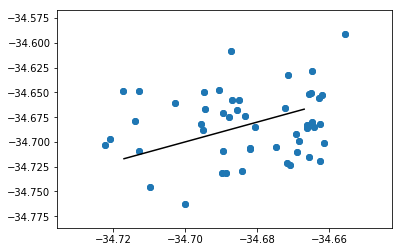

In [39]:
Natoms = len(db[0])
plt.scatter(np.array(qm_energies)/Natoms, np.array(gap2b_energies)/Natoms)
plt.plot([E0-5.0, E0-5.0+0.05], [E0-5.0, E0-5.0+0.05], "k-")
plt.show()

We can also calculate the RMSE (in meV) as follows:

In [40]:
np.sqrt(sum((np.array(qm_energies)/Natoms - np.array(gap2b_energies)/Natoms)**2)/len(gap2b_energies))

0.035992967464800296

We can generate dimers for visualising the pairwise potential: 

In [41]:
dimers = [Atoms("2Si", positions=[[0,0,0], [x, 0,0]]) for x in np.linspace(1.6,6,100)] 

In [42]:
dimer_curve = []
for dim in dimers:
    dim.set_calculator(gap2b)
    dimer_curve.append(dim.get_potential_energy())

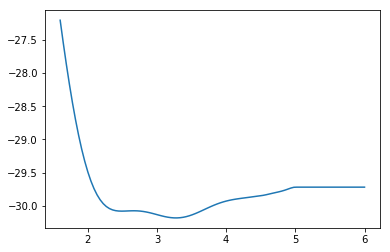

In [43]:
plt.plot([dim.positions[1,0] for dim in dimers], np.array(dimer_curve)/2.0)
plt.show()

## Fitting the 2 and 3-body potential

In [44]:
!gap_fit at_file=/tmp/atoms_db.xyz \
gap={distance_Nb order=2 \
                 cutoff=5.0 \
                 covariance_type=ARD_SE \
                 theta_uniform=1.0 \
                 n_sparse=15 \
                 delta=1.0:\
     distance_Nb order=3 \
                 cutoff=4.0 \
                 covariance_type=ARD_SE \
                 theta_uniform=1.0 \
                 n_sparse=50 \
                 delta=0.004} \
e0=-29.716948405885105 \
default_sigma={0.005 0.5 0.0 0.0} \
do_copy_at_file=F sparse_separate_file=F \
gp_file=/tmp/gap_3b.xml

libAtoms::Hello World: 07/10/2019   17:17:09
libAtoms::Hello World: git version  git@github.com:/libAtoms/QUIP,d204dca49-dirty
libAtoms::Hello World: QUIP_ARCH    darwin_x86_64_gfortran_openmp
libAtoms::Hello World: compiled on  Aug  7 2019 at 14:13:45
libAtoms::Hello World: OpenMP parallelisation with 4 threads
libAtoms::Hello World: Random Seed = 62229764
libAtoms::Hello World: global verbosity = 0

Calls to system_timer will do nothing by default


================================ Input parameters ==============================

at_file = /tmp/atoms_db.xyz
gap = "distance_Nb order=2 cutoff=5.0 covariance_type=ARD_SE theta_uniform=1.0 n_sparse=15 delta=1.0: distance_Nb order=3 cutoff=4.0 covariance_type=ARD_SE theta_uniform=1.0 n_sparse=50 delta=0.004"
e0 = -29.716948405885105
local_property0 = 0.0
e0_offset = 0.0
e0_method = isolated
default_sigma = "0.005 0.5 0.0 0.0"
sparse_jitter = 1.0e-10
hessian_delta = 1.0e-2
core_param_file = quip_params.xml
core_ip_args =
energy_parameter_na

We can load and use the fitted potential:

In [45]:
gap3b = Potential(param_filename='/tmp/gap_3b.xml')
gap3b_energies = []
for at in db:
    a = at.copy()
    a.set_calculator(gap3b)
    gap3b_energies.append(a.get_potential_energy())
    

We can also calculate the RMSE (in meV) as follows:

In [46]:
np.sqrt(sum((np.array(qm_energies)/Natoms - np.array(gap3b_energies)/Natoms)**2)/len(gap3b_energies))

0.010408552706046549

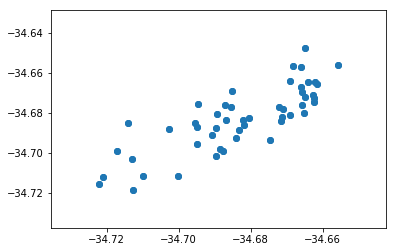

In [47]:
plt.scatter(np.array(qm_energies)/Natoms, np.array(gap3b_energies)/Natoms)
plt.show()

We can generate dimers for visualising the pairwise potential: 

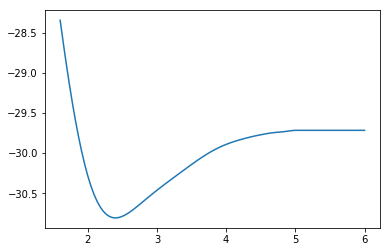

In [48]:
dimer_curve = []
for dim in dimers:
    dim.set_calculator(gap3b)
    dimer_curve.append(dim.get_potential_energy())
    
plt.plot([dim.positions[1,0] for dim in dimers], np.array(dimer_curve)/2.0)
plt.show()

## Fitting the 2 and 3-body  and SOAP potential

We will describe that environment using the SOAP descriptor and compare them using the SOAP kernel. Note right away that the quantum mechanically computed energies are not fully determined by the near-environment of atoms, so this is an early indication that we will be making use of the "noise" interpretation of the $\lambda$ regularization parameter: we don't expect (and don't want) our fitted function to precisely go through each datapoint.

The SOAP descriptor of an atomic environment is based on a spherical harmonic expansion of the neighbour density, and truncating this expansion at some maximum numer of radial (n_max) and angular (l_max) indices gives rise to some parameters. We also need to give the cutoff within which we consider the neighbour environment.

Writing the descriptor vector as $p_{ss'nn'l}$, where $s$ and $s'$ are indices that run over the different atomic species in the atom's environment, $n$ and $n'$ are radial and $l$ is an angular index, the kernel between two atomic environments is

$$
K(p,p') = \delta^2 \left| \sum_{ss'nn'l} p_{ss'nn'l} p'_{ss'nn'l}\right|^\zeta \equiv \delta^2 \left| {\bf p} \cdot {\bf p'}\right|^\zeta
$$

The factor of $\delta^2$ allows the setting of the scale of fitted function, relative to the error specification $\lambda$. 

In [49]:
!gap_fit at_file=/tmp/atoms_db.xyz \
gap={distance_Nb order=2 \
                 cutoff=5.0 \
                 covariance_type=ARD_SE \
                 theta_uniform=1.0 \
                 n_sparse=15 \
                 delta=1.0:\
     distance_Nb order=3 \
                 cutoff=4.0 \
                 covariance_type=ARD_SE \
                 theta_uniform=1.0 \
                 n_sparse=50 \
                 delta=0.004:\
     soap cutoff=4.0 \
          covariance_type=dot_product \
          zeta=2 \
          delta=0.016 \
          atom_sigma=0.7 \
          l_max=6 \
          n_max=6 \
          n_sparse=200 \
          sparse_method=cur_points} \
e0=-29.716948405885105 \
default_sigma={0.001 0.5 0.0 0.0} \
do_copy_at_file=F sparse_separate_file=F \
gp_file=/tmp/gap_2b3bsoap.xml 2>&1 | grep -v FoX

libAtoms::Hello World: 07/10/2019   17:17:32
libAtoms::Hello World: git version  git@github.com:/libAtoms/QUIP,d204dca49-dirty
libAtoms::Hello World: QUIP_ARCH    darwin_x86_64_gfortran_openmp
libAtoms::Hello World: compiled on  Aug  7 2019 at 14:13:45
libAtoms::Hello World: OpenMP parallelisation with 4 threads
libAtoms::Hello World: Random Seed = 62252544
libAtoms::Hello World: global verbosity = 0

Calls to system_timer will do nothing by default


================================ Input parameters ==============================

at_file = /tmp/atoms_db.xyz
gap = "distance_Nb order=2 cutoff=5.0 covariance_type=ARD_SE theta_uniform=1.0 n_sparse=15 delta=1.0: distance_Nb order=3 cutoff=4.0 covariance_type=ARD_SE theta_uniform=1.0 n_sparse=50 delta=0.004: soap cutoff=4.0 covariance_type=dot_product zeta=2 delta=0.016 atom_sigma=0.7 l_max=6 n_max=6 n_sparse=200 sparse_method=cur_points"
e0 = -29.716948405885105
local_property0 = 0.0
e0_offset = 0.0
e0_method = isolated
default_sigma = "0

We can load and use the fitted potential:

In [50]:
gap_soap = Potential(param_filename='/tmp/gap_2b3bsoap.xml')
gap_energies = []
for at in db:
    a = at.copy()
    a.set_calculator(gap_soap)
    gap_energies.append(a.get_potential_energy())

We can also calculate the RMSE (in meV) as follows:

In [51]:
np.sqrt(sum((np.array(qm_energies)/Natoms - np.array(gap_energies)/Natoms)**2)/len(gap_energies))

0.004254157149981674

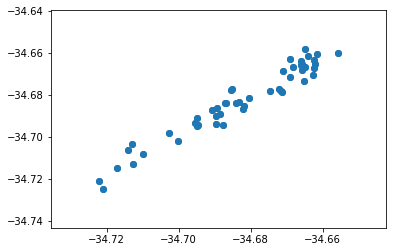

In [52]:
plt.scatter(np.array(qm_energies)/Natoms, np.array(gap_energies)/Natoms)
plt.show()

## Using GAP for MD
We can use now use the fitted potential to do MD or geometry relaxation:

In [53]:
#attach tight binding calculator
atoms.set_calculator(gap_soap)

# Thermalize atoms
# MaxwellBoltzmannDistribution(atoms, 2.0* T * units.kB)

# dynamics = VelocityVerlet(atoms, timestep)
dynamics = Langevin(atoms, timestep, T * units.kB, 0.002)
    
dynamics.attach(print_status, interval=10)
dynamics.attach(print_energy, interval=10)

Dynamics:

In [54]:
dynamics.run(steps=100)

Step = 0, time = 0.0 [fs], T = 1294.479828341841 [K]
Energy per atom: Epot = -34.698eV  Ekin = 0.167eV (T=1294K)  Etot = -34.531eV
Step = 10, time = 10.0 [fs], T = 1189.7904138587505 [K]
Energy per atom: Epot = -34.685eV  Ekin = 0.154eV (T=1190K)  Etot = -34.531eV
Step = 20, time = 20.0 [fs], T = 1264.3379093179376 [K]
Energy per atom: Epot = -34.696eV  Ekin = 0.163eV (T=1264K)  Etot = -34.533eV
Step = 30, time = 30.0 [fs], T = 1457.3725237044011 [K]
Energy per atom: Epot = -34.721eV  Ekin = 0.188eV (T=1457K)  Etot = -34.533eV
Step = 40, time = 40.0 [fs], T = 1388.8679832826024 [K]
Energy per atom: Epot = -34.715eV  Ekin = 0.180eV (T=1389K)  Etot = -34.536eV
Step = 50, time = 50.00000000000001 [fs], T = 1561.736378264197 [K]
Energy per atom: Epot = -34.738eV  Ekin = 0.202eV (T=1562K)  Etot = -34.536eV
Step = 60, time = 60.0 [fs], T = 2028.6943305981565 [K]
Energy per atom: Epot = -34.800eV  Ekin = 0.262eV (T=2029K)  Etot = -34.538eV
Step = 70, time = 70.0 [fs], T = 1568.5562709553685 [

True

Geometry optimisation:

In [55]:
optatoms = db[0].copy()
optatoms.set_calculator(gap_soap)
opt = PreconLBFGS(optatoms, precon=Exp(3.0))

In [56]:
opt.run(fmax=0.01)

PreconLBFGS:   0  17:18:02    -1109.683388       4.9234
estimate_mu(): mu=1.4377293786564451, mu_c=1.0
PreconLBFGS:   1  17:18:02    -1110.535572       4.5917
PreconLBFGS:   2  17:18:02    -1111.272884       4.5079
PreconLBFGS:   3  17:18:02    -1111.957952       4.3767
PreconLBFGS:   4  17:18:02    -1112.578689       4.3500
PreconLBFGS:   5  17:18:02    -1113.225669       4.3169
PreconLBFGS:   6  17:18:02    -1113.863449       4.2918
PreconLBFGS:   7  17:18:03    -1114.471548       4.2458
PreconLBFGS:   8  17:18:03    -1115.032581       4.1511
PreconLBFGS:   9  17:18:03    -1115.574963       4.0274
PreconLBFGS:  10  17:18:03    -1116.119287       3.8739
PreconLBFGS:  11  17:18:03    -1116.680878       3.6919
PreconLBFGS:  12  17:18:03    -1117.209393       3.5311
PreconLBFGS:  13  17:18:03    -1117.716249       3.3508
PreconLBFGS:  14  17:18:03    -1118.160184       3.2262
PreconLBFGS:  15  17:18:03    -1118.601303       3.0357
PreconLBFGS:  16  17:18:03    -1118.990945       2.9062
P

Passed direction which is not downhill. Aborting...


PreconLBFGS:  76  17:18:09    -1127.698444       1.0778
PreconLBFGS:  77  17:18:10    -1127.719816       1.0899


/Users/jameskermode/.pyenv/versions/3.6.6/Python.framework/Versions/3.6/lib/python3.6/site-packages/ase/optimize/precon/lbfgs.py:352: UserWarning: Armijo linesearch failed, resetting Hessian and trying again
  'Armijo linesearch failed, resetting Hessian and '


PreconLBFGS:  78  17:18:10    -1127.761700       1.1322
PreconLBFGS:  79  17:18:10    -1127.844255       1.2291
PreconLBFGS:  80  17:18:10    -1127.969036       1.3938
PreconLBFGS:  81  17:18:10    -1128.081393       1.4121
PreconLBFGS:  82  17:18:10    -1128.181345       1.3558
PreconLBFGS:  83  17:18:10    -1128.270254       1.3927
PreconLBFGS:  84  17:18:10    -1128.348531       1.5283
PreconLBFGS:  85  17:18:10    -1128.426889       1.7799
PreconLBFGS:  86  17:18:11    -1128.445736       1.8243


Passed direction which is not downhill. Aborting...


PreconLBFGS:  87  17:18:11    -1128.445736       1.8243
PreconLBFGS:  88  17:18:11    -1128.482902       1.9309
PreconLBFGS:  89  17:18:11    -1128.559965       2.2312


Passed direction which is not downhill. Aborting...


PreconLBFGS:  90  17:18:11    -1128.559965       2.2312
PreconLBFGS:  91  17:18:11    -1128.670491       2.4921


Passed direction which is not downhill. Aborting...


PreconLBFGS:  92  17:18:11    -1128.670491       2.4921
PreconLBFGS:  93  17:18:11    -1128.782318       2.3591
PreconLBFGS:  94  17:18:11    -1128.894364       2.1521
PreconLBFGS:  95  17:18:11    -1129.001220       2.2479
PreconLBFGS:  96  17:18:11    -1129.106928       2.3316


Passed direction which is not downhill. Aborting...


PreconLBFGS:  97  17:18:11    -1129.106928       2.3316
PreconLBFGS:  98  17:18:11    -1129.220418       2.3091
PreconLBFGS:  99  17:18:12    -1129.331678       2.2090
PreconLBFGS: 100  17:18:12    -1129.443932       2.0163
PreconLBFGS: 101  17:18:12    -1129.551115       1.6623
PreconLBFGS: 102  17:18:12    -1129.652255       1.2197
PreconLBFGS: 103  17:18:12    -1129.733200       0.8105
PreconLBFGS: 104  17:18:12    -1129.793145       0.6091
PreconLBFGS: 105  17:18:12    -1129.830076       0.5602
PreconLBFGS: 106  17:18:12    -1129.844974       0.3316
PreconLBFGS: 107  17:18:12    -1129.853075       0.4243
PreconLBFGS: 108  17:18:13    -1129.857980       0.2636
PreconLBFGS: 109  17:18:13    -1129.861664       0.1665
PreconLBFGS: 110  17:18:13    -1129.863643       0.1211
PreconLBFGS: 111  17:18:13    -1129.864671       0.0906
PreconLBFGS: 112  17:18:13    -1129.865139       0.0449
PreconLBFGS: 113  17:18:13    -1129.865458       0.0324
PreconLBFGS: 114  17:18:14    -1129.865586      

True

Let's visualise the relaxed structure:

In [57]:
view = ViewStructure(optatoms, (2,2,1))
view.camera= 'orthographic'
view

NGLWidget()